In [2]:
!pip install langchain langgraph langsmith langchain-groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

In [3]:
groq_api_key = "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"

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-20b", groq_api_key=groq_api_key)

In [5]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

@tool
def grammar_corrector(text: str) -> str:
    """Fix grammar, punctuation, agreement, and basic fluency without changing meaning."""
    out = llm.invoke([HumanMessage(content=f"Fix grammar: {text}")])
    return out.content

@tool
def sentence_rewriter(text: str, goal: str = "clarity & concision") -> str:
    """Rewrite sentences to improve structure and readability while preserving meaning."""
    out = llm.invoke([HumanMessage(content=f"Rewrite the text to maximize {goal}. Keep meaning. Return only the rewrite:\n\n{text}")])
    return out.content

@tool
def tone_adjuster(text: str, tone: str = "neutral") -> str:
    """Adjust tone while preserving meaning. Examples: formal, friendly, academic, persuasive."""
    out = llm.invoke([HumanMessage(content=f"Rewrite the text in a '{tone}' tone. Keep meaning. Return only the rewritten text:\n\n{text}")])
    return out.content

In [6]:
tools = [grammar_corrector, sentence_rewriter, tone_adjuster]
llm_with_tool = llm.bind_tools(tools)


class State(TypedDict):
    messages: Annotated[list, add_messages]

def tool_calling_llm(state: State):
    return {
        "messages": [llm_with_tool.invoke(state["messages"])]
        }

In [11]:
# Graph
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges("tool_calling_llm", tools_condition)

graph_builder.add_edge("tools", "tool_calling_llm")

graph = graph_builder.compile()


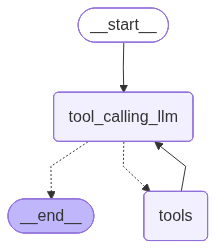

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
from langchain_core.messages import SystemMessage
SYSTEM_POLICY = SystemMessage(content="""
You are an AI Writing Assistant.
1) If there are errors, call grammar_corrector first.
2) If clarity/structure is requested (or implied), call sentence_rewriter next.
3) If tone is requested (formal/friendly/academic/persuasive), call tone_adjuster.
4) When done, reply with only the final improved text.
""".strip())


In [16]:
user_text = input("Enter your text: ")
response = graph.invoke({
    "messages": [SYSTEM_POLICY, HumanMessage(content=user_text)]
})
print(response)

Enter your text: I love eat burger. i eat coffe. yesterdy, i play foofvall.and that time more rain come suddenly and it was add more enjoyable in the playing time.. Please write this senctence correctly in grammar. and rewrite this in formal tone
{'messages': [SystemMessage(content='You are an AI Writing Assistant.\n1) If there are errors, call grammar_corrector first.\n2) If clarity/structure is requested (or implied), call sentence_rewriter next.\n3) If tone is requested (formal/friendly/academic/persuasive), call tone_adjuster.\n4) When done, reply with only the final improved text.', additional_kwargs={}, response_metadata={}, id='0847be2b-5af9-403f-ba94-3ac649c035ff'), HumanMessage(content='I love eat burger. i eat coffe. yesterdy, i play foofvall.and that time more rain come suddenly and it was add more enjoyable in the playing time.. Please write this senctence correctly in grammar. and rewrite this in formal tone', additional_kwargs={}, response_metadata={}, id='4817d764-3a3b-4

In [17]:
from langchain_core.messages import AIMessage

print("Final Improved Text")
for m in response["messages"]:
    if isinstance(m, AIMessage):
        print(m.content)

Final Improved Text


I enjoy consuming burgers and drinking coffee. Yesterday, I participated in a football match. Unexpectedly, it began to rain, which enhanced the enjoyment of the game.
